In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Seed
torch.manual_seed(0)
np.random.seed(0)

# Prepare dataset

In [5]:
class MNIST_Temporal(datasets.MNIST):
    def __init__(self, root, train=True, download=True, transform=transforms.ToTensor(),
                 time_steps=25, t_max=1.0):
        """
        MNIST dataset with temporal (latency) encoding.
        
        Args:
            root: Root directory of dataset
            train: If True, creates dataset from training set, else from test set
            download: If True, downloads the dataset
            transform: pytorch transforms for preprocessing
            time_steps: Number of time steps for encoding
            t_max: Maximum time value (neurons with 0 intensity will spike at t_max)
        """
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.time_steps = time_steps
        self.t_max = t_max
    
    def __getitem__(self, index):
        """Get temporally encoded sample from dataset"""
        img, target = super().__getitem__(index)
        # Reshape image to 784 pixels (flattened 28x28)
        img_flat = img.view(-1)
        
        # Temporal encoding: Convert pixel intensity to spike timing
        # Higher intensity (closer to 1) = earlier spike (closer to 0)
        # Lower intensity (closer to 0) = later spike (closer to t_max)
        # Pixels with intensity 0 will not spike (set to t_max)
        
        # Create temporal encoding where spike_time = (1-intensity) * t_max
        temporal_code = (1.0 - img_flat) * self.t_max
        
        # Convert continuous time to discrete time steps
        temporal_code = (temporal_code * self.time_steps).long()
        
        # Generate one-hot encoded tensor of size [time_steps, 784]
        spikes = torch.zeros(self.time_steps, 784)
        # For each neuron, set spike to 1 at its specific time step
        for i, t in enumerate(temporal_code):
            if t < self.time_steps:  # Ensure time index is valid
                spikes[t, i] = 1.0
        
        return spikes, target

In [11]:
# Data Loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST_Temporal(root='../data', train=True, download=True, transform=transform)
test_dataset = MNIST_Temporal(root='../data', train=False, download=True, transform=transform)

# split train dataset for train and validation
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Filter out zeros from training data
train_data = []
train_labels = []
for data, label in train_dataset:
    if label != 0:
        train_data.append(data)
        train_labels.append(label)

# Keep all training data
train_data = torch.stack(train_data)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Keep all validation data
val_data = torch.stack([data for data, _ in val_set])
val_labels = torch.tensor([label for _, label in val_set])
val_loader = DataLoader(TensorDataset(val_data, val_labels), batch_size=128)

# Keep all test data
test_data = torch.stack([data for data, _ in test_dataset])
test_labels = torch.tensor([label for _, label in test_dataset])
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=128)


In [15]:
print(torch.unique(torch.tensor(val_labels), return_counts=True))
print(torch.unique(torch.tensor(test_labels), return_counts=True))
print(torch.unique(torch.tensor(train_labels), return_counts=True))

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 959, 1085, 1015, 1052,  994,  906,  963, 1119,  956,  951]))
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))
(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


/var/folders/5f/82lq0pq96q17kcpzwpq3dlm40000gn/T/ipykernel_51615/435634570.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.unique(torch.tensor(val_labels), return_counts=True))
/var/folders/5f/82lq0pq96q17kcpzwpq3dlm40000gn/T/ipykernel_51615/435634570.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.unique(torch.tensor(test_labels), return_counts=True))


In [13]:
# ------------------- -------------------
# Decrease amount of 1-9 digits in validation data set to 1/9 of its current amount
# ------------------- -------------------

indices_1_9 = (val_labels != 0).nonzero(as_tuple=True)[0]
indices_1_9 = val_labels != 0
indices_0 = val_labels == 0

print(len(val_data[indices_0]))
print(len(val_data[indices_1_9]))

# Randomly choose 1000 examples from val_data[indices_1_9]
num_samples = 1000
random_indices = torch.randperm(len(val_data[indices_1_9]))[:num_samples]
val_data_reduced = val_data[indices_1_9][random_indices]
val_labels_reduced = val_labels[indices_1_9][random_indices]

print(len(val_data_reduced))
print(len(val_labels_reduced))

print(torch.unique(val_labels_reduced, return_counts=True))

val_data_reduced = torch.cat((val_data_reduced, val_data[indices_0]), dim=0)
val_labels_reduced = torch.cat((val_labels_reduced, val_labels[indices_0]), dim=0)

print(len(val_data_reduced))
print(len(val_labels_reduced))

print(torch.unique(val_labels_reduced, return_counts=True))

# Reduced validation data loader
val_loader_reduced = DataLoader(TensorDataset(val_data_reduced, val_labels_reduced), batch_size=128, shuffle=True) # shuffle is optional

959
9041
1000
1000
(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([112, 131, 113, 112,  95, 102, 134,  99, 102]))
1959
1959
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([959, 112, 131, 113, 112,  95, 102, 134,  99, 102]))


Train data shape: torch.Size([54077, 25, 784])
Validation data shape: torch.Size([10000, 25, 784])
Reduced validation data shape: torch.Size([1959, 25, 784])
Test data shape: torch.Size([10000, 25, 784])

Train labels distribution: (tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
Validation labels distribution: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 959, 1085, 1015, 1052,  994,  906,  963, 1119,  956,  951]))
Reduced validation labels distribution: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([959, 112, 131, 113, 112,  95, 102, 134,  99, 102]))
Test labels distribution: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


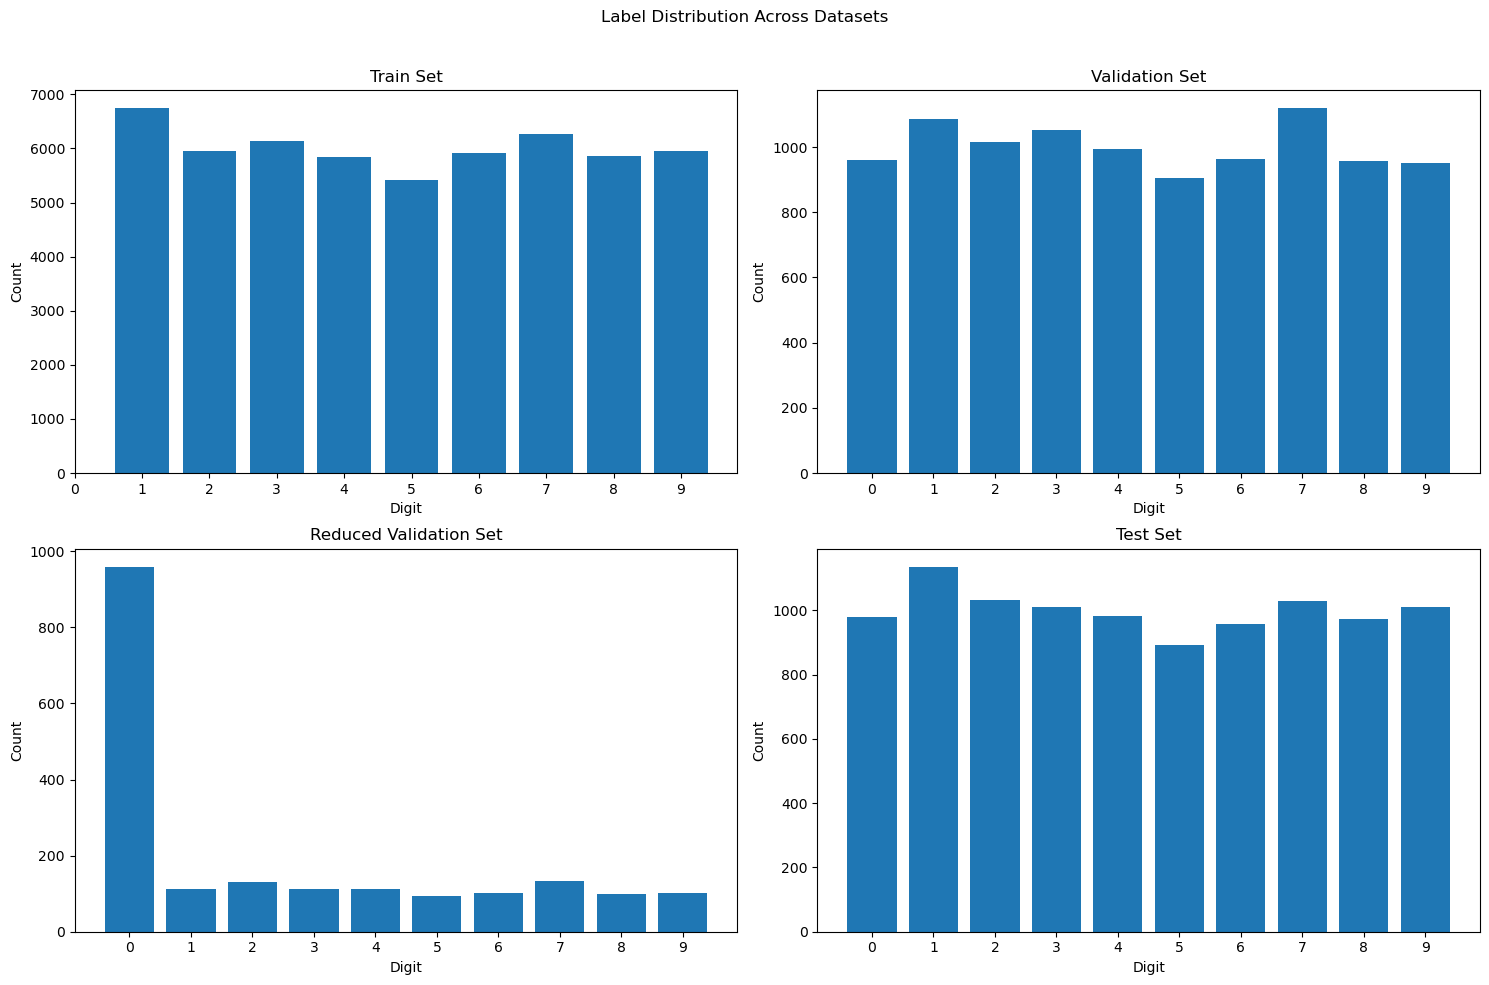

In [14]:
# Print shape of each dataset
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Reduced validation data shape:", val_data_reduced.shape)
print("Test data shape:", test_data.shape)

# Print distribution of labels in each dataset
print("\nTrain labels distribution:", torch.unique(torch.tensor(train_labels), return_counts=True))
print("Validation labels distribution:", torch.unique(val_labels, return_counts=True))
print("Reduced validation labels distribution:", torch.unique(val_labels_reduced, return_counts=True))
print("Test labels distribution:", torch.unique(test_labels, return_counts=True))

# Visualize the distribution as bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Label Distribution Across Datasets')

# Helper function to plot distribution
def plot_distribution(ax, labels, title):
  if isinstance(labels, list):
    labels = torch.tensor(labels)
  unique, counts = torch.unique(labels, return_counts=True)
  ax.bar(unique.numpy(), counts.numpy())
  ax.set_xlabel('Digit')
  ax.set_ylabel('Count')
  ax.set_title(title)
  ax.set_xticks(range(10))

# Plot distributions
plot_distribution(axes[0, 0], train_labels, 'Train Set')
plot_distribution(axes[0, 1], val_labels, 'Validation Set')
plot_distribution(axes[1, 0], val_labels_reduced, 'Reduced Validation Set')
plot_distribution(axes[1, 1], test_labels, 'Test Set')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Spike tensor shape: torch.Size([128, 25, 784])
Sample label: 0


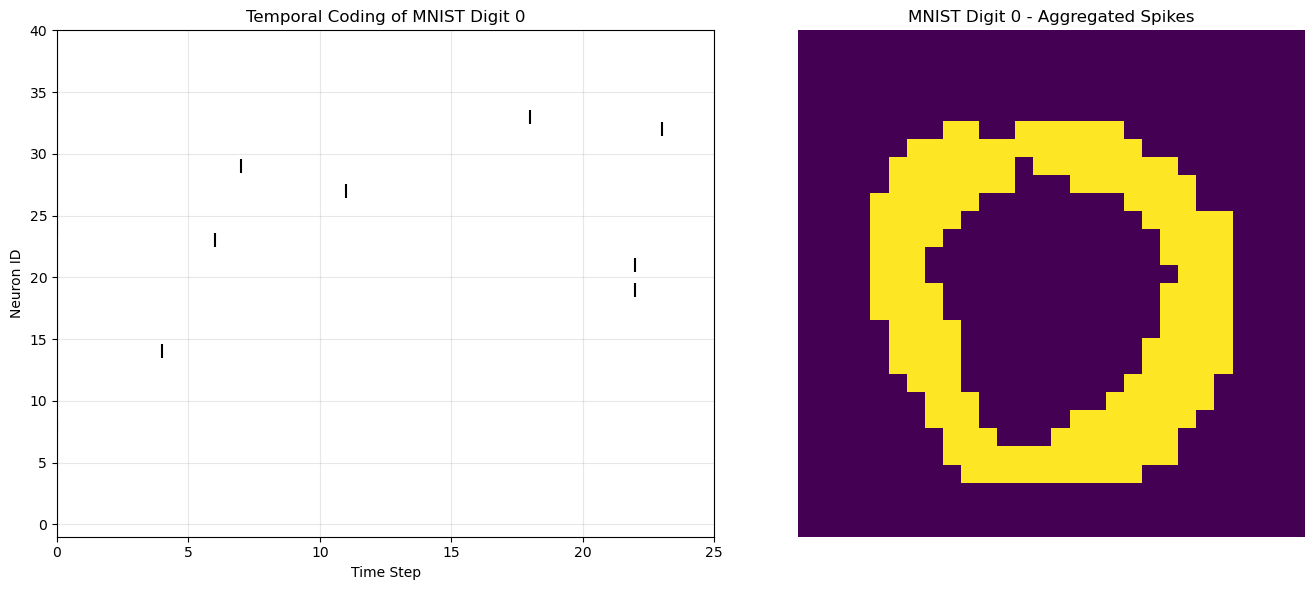

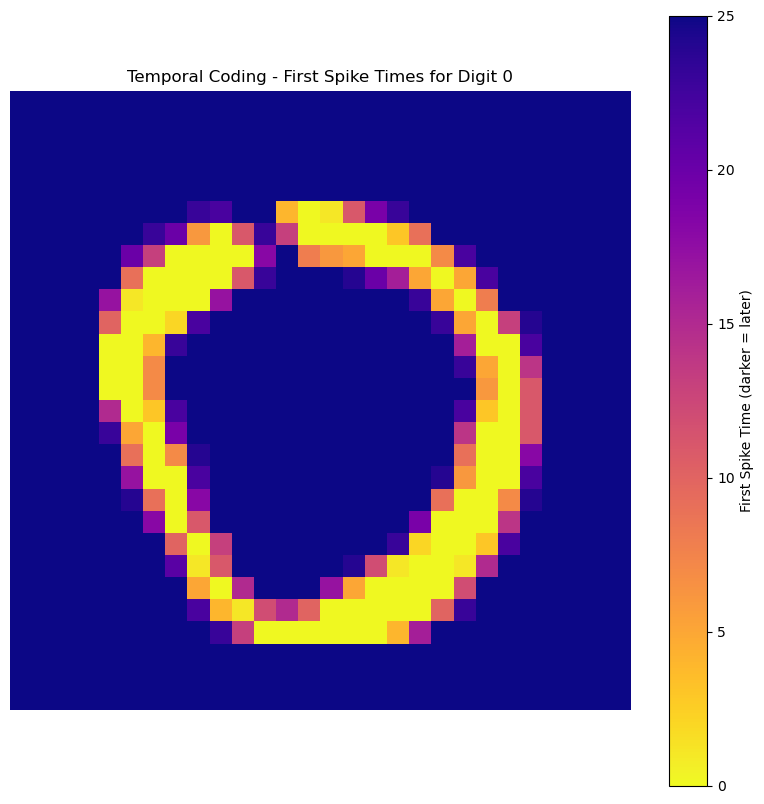

In [16]:
# Get a sample and visualize
time_steps = 25  # Number of time steps

sample_spikes, sample_label = next(iter(val_loader_reduced))
print(f"Spike tensor shape: {sample_spikes.shape}")
print(f"Sample label: {sample_label[0]}")

# Visualize the temporal coding
def visualize_temporal_encoding(spike_tensor, label, neuron_indices=None):
  """Visualize temporal encoding for selected neurons"""
  import numpy as np
  
  if neuron_indices is None:
    # Choose 40 random neurons to visualize - enough to see a pattern
    neuron_indices = torch.randint(0, 784, (40,))
  
  # Extract the spikes for the selected neurons
  selected_neuron_data = spike_tensor[0, :, neuron_indices].cpu().numpy()
  
  # Create a more informative visualization
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
  
  # Plot 1: Spike raster plot
  for i in range(selected_neuron_data.shape[1]):
    spike_times = np.where(selected_neuron_data[:, i] > 0)[0]
    if len(spike_times) > 0:  # Some neurons might not spike
      ax1.scatter(spike_times, np.ones_like(spike_times) * i, marker='|', s=100, color='black')
  
  ax1.set_title(f"Temporal Coding of MNIST Digit {label[0].item()}")
  ax1.set_xlabel("Time Step")
  ax1.set_ylabel("Neuron ID")
  ax1.set_xlim(0, time_steps)  # Use the global time_steps variable
  ax1.set_ylim(-1, len(neuron_indices))
  ax1.grid(True, alpha=0.3)
  
  # Plot 2: 2D visualization of the digit
  # Reshape the first image to 28x28
  digit_image = spike_tensor[0, :, :].sum(dim=0).view(28, 28).cpu().numpy()
  ax2.imshow(digit_image, cmap='viridis')
  ax2.set_title(f"MNIST Digit {label[0].item()} - Aggregated Spikes")
  ax2.axis('off')
  
  plt.tight_layout()
  plt.show()
  
  # Also create a heatmap showing when each pixel spikes
  plt.figure(figsize=(10, 10))
  
  # Find the first spike time for each pixel (set to time_steps if no spike)
  first_spike_times = np.ones((28, 28)) * time_steps
  for t in range(time_steps):
    spike_frame = spike_tensor[0, t, :].view(28, 28).cpu().numpy()
    mask = (spike_frame > 0) & (first_spike_times == time_steps)  # Only update pixels that haven't spiked yet
    first_spike_times[mask] = t
  
  # Plot the first spike times
  plt.imshow(first_spike_times, cmap='plasma_r')  # Reverse colormap so early spikes are bright
  plt.colorbar(label='First Spike Time (darker = later)')
  plt.title(f"Temporal Coding - First Spike Times for Digit {label[0].item()}")
  plt.axis('off')
  plt.show()

# Visualize a sample
visualize_temporal_encoding(sample_spikes, sample_label)